# **Import and Install Necessary Packages**

## Spark

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
    !tar xf spark-3.2.1-bin-hadoop3.2.tgz
    !mv spark-3.2.1-bin-hadoop3.2 spark
    !pip install -q findspark

if IN_COLAB:
  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["SPARK_HOME"] = "/content/spark"

## Other libraries

In [2]:
!pip install xlrd==1.2.0

     |████████████████████████████████| 103 kB 7.8 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [3]:
import os
import pandas as pd
import numpy as np
import xlrd
import matplotlib.pyplot as plt
import sys

from datetime import datetime, timedelta

def get_current_dt():
    current_dt = datetime.now()
    return current_dt.strftime('%Y-%m-%d %H:%M:%S')

# **Mount Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Change Directory Here
%cd /content/drive/MyDrive/my university life/YEAR 3 - JUNIOR/Data Science and Data Engineering/Project_2/Project2_ใจผมสลายฮะมุง/source_code

/content/drive/.shortcut-targets-by-id/16B6ICb8qhZrf82Cq0T0DVTKCwJjFS95s/Project_2/Project2_ใจผมสลายฮะมุง/source_code


# **Start a Spark Local Cluster**

In [6]:
import findspark
findspark.init()

cluster_url = 'local'
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master(cluster_url)\
        .appName('SparkSQL')\
        .getOrCreate()

In [7]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Read Excel File and Convert to appropriate csv File using Pandas

In [8]:
def mapping_column_names(c):
    if c in ["CO(ppm) at 3 m"]:
        return "CO at 3 m (ppm)"

    elif c in ["CO(8) at 3 m (ppm)"]:
        return "CO8 at 3 m (ppm)"

    elif c in ["Glob rad (w/m2)"]:
        return "Glob rad at 3 m (w/m2)"

    elif c in ["Nox at 3 m (ppb)", "NOX at 3 m (ppb)"]:
        return "NOx at 3 m (ppb)"

    elif c in ["Net rad (w/m2)"]:
        return "Net rad at 3 m (w/m2)"
    
    elif c in ["PM10 at 3 m (มคก./ลบ.ม.)", "PM10(มคก./ลบ.ม.) at 3 m"]:
        return "PM10 at 3 m (microg/m3)"
    
    elif c in ["PM2.5 at 3 m (มคก./ลบ.ม.)"]:
        return "PM2_5 at 3 m (microg/m3)"
    
    elif c in ["Pressure at 2 m (mmhg)"]:
        return "Pressure at 2 m (mmHg)"

    elif c in ["RAIN at 3 m (mm)", "RAIN at 3 m (mm)16", "Rain at 3 m (mm)", "Rain at 3 m (mm)9"]:
        return "Rain at 3 m (mm)"

    elif c in ["RH at 2 m (%RH)", "Rel hum at 2 m (%)", "Rel hum at 2 m (%RH)"]:
        return "RH at 2 m (%)"
    
    elif c in ["RH at 3 m (%RH)", "Rel hum at 3 m (%RH)"]:
        return "RH at 3 m (%)"
    
    elif c in ["Rel hum at 10 m (%RH)"]:
        return "RH at 10 m (%)"

    elif c in ["SD", "SD DEG"]:
        return "SD (Deg)"
    
    elif c in ["Std wdir.1 10", "Std wdir 10", "Std wdir at 10"]:
        return "Std_wdir at 10"
    
    elif c in ["Std wdir.1 30"]:
        return "Std_wdir at 30"
    
    elif c in ["Std_wspd.1 V"]:
        return "Std_wspd V"
    
    elif c in ["Std_wspd.2 W"]:
        return "Std_wspd W"

    elif c in ["TEMP at 2 m", "Temp at 2m", "Temp at 2 m"]:
        return "Temp at 2 m (oC)"

    elif c in ["TEMP at 3 m", "TEMP at 3 m13", "TEMP at 3 m14", "TMP at 3 m", "Temp at 3 m", "Temp at 3 m8"]:
        return "Temp at 3 m (oC)"
    
    elif c in ["Temp at 10 m"]:
        return "Temp at 10 m (oC)"
    
    elif c in ["WD at 10 m (Deg.M)", "Wind dir at 10 m (Deg.M)"]:
        return "Wind_dir at 10 m (DegM)"
    
    elif c in ["Wind dir.1 at 20 m (Deg.M)"]:
        return "Wind_dir at 20 m (DegM)"
    
    elif c in ["Wind dir at 30 m (Deg.M)", "Wind dir.1 at 30 m (Deg.M)"]:
        return "Wind_dir at 30 m (DegM)"

    elif c in ["WS at 10 m (DegM)", "WS at 10 m (m/s)", "Wind speed at 10 m (m/s)"]:
        return "Wind_speed at 10 m (m/s)"
    
    elif c in ["Wind speed at 30 m (m/s)"]:
        return "Wind_speed at 30 m (m/s)"
    
    elif c in ["WS comp  U10"]:
        return "WS comp U10"
    
    elif c in ["WS comp.1  U30"]:
        return "WS comp U30"
    
    elif c in ["WS comp.2  V10"]:
        return "WS comp V10"

    elif c in ["WS comp.3  V30"]:
        return "WS comp V30"

    elif c in ["WS comp.4  W10"]:
        return "WS comp W10"

    elif c in ["WS comp.5  W30"]:
        return "WS comp W30"

    elif c in ["วัน/เดือน/ปี"] or c.startswith("ปี/เดือน/วัน"):
        return "ปี/เดือน/วัน"

    else:
        return c

In [9]:
def combine_first_row_to_column(df):
    new_columns = []
    for i in range (len(df.columns)):
        x1 = str(df.columns[i].strip())
        x2 = str(df.iloc[0][df.columns[i]]) if str(df.iloc[0][df.columns[i]]) != 'nan' else ''
        new_columns.append((x1 + ' ' + x2).strip())
    df.columns = new_columns
    #drop first row
    df = df.iloc[1: ]
    return df

def convert_excel_to_csv_file(stationID, filePath):
    dfs = list(pd.read_excel(filePath, sheet_name = None).values()) #sheet_name = None --> read all sheets in excel files
    dfs = list(map(lambda df: combine_first_row_to_column(df.loc[:,  ~df.columns.str.contains('^Unnamed')]), dfs)) #remove Unnamed Columns and combine first row to columns

    #mapping column names for each df in dfs
    for i in range (len(dfs)):
        new_col_names = []
        for c in dfs[i].columns:
            new_col_names.append(mapping_column_names(c))
        dfs[i].columns = new_col_names

    # for debugging ==============================================
    # for i in range (len(dfs)):
    #     print(dfs[i].columns)
    # ============================================================

    # special case ===============================================
    if stationID in ["14t"]:
        dfs[1] = dfs[1].iloc[:, 1:]
    # ============================================================

    df = pd.concat(dfs, axis = 0)
    
    #drop row which 'ปี/เดือน/วัน' and 'ชั่วโมง' is null
    df = df[df['ปี/เดือน/วัน'].notna()]
    df = df[df['ชั่วโมง'].notna()]

    df['ปี/เดือน/วัน'] = df['ปี/เดือน/วัน'].astype('int').astype('string')
    df['ชั่วโมง'] = df['ชั่วโมง'].astype('int').astype('string')

    df.reset_index(drop = True, inplace = True)
    return df

In [10]:
df_stations = pd.read_csv('./processed_data/PCD_Data_Before_Stations.csv')
df_stations

,stationID,stationName,filePath,fileType
0,02t,มหาวิทยาลัยราชภัฏบ้านสมเด็จเจ้าพระยา,./data/PCD Data/Data before 2020-9/ambient/(02...,.xlsx
1,03t,ริมถนนกาญจนาภิเษก เขตบางขุนเทียน,./data/PCD Data/Data before 2020-9/roadside/(0...,.xlsx
2,03t_1,ไปรษณีย์ราษฎร์บูรณะ (ปิดสถานี),./data/PCD Data/Data before 2020-9/ambient/(03...,.xlsx
3,03t_2,หมวดการทางบางขุนเทียนที่ 2(ปิดสถานี),./data/PCD Data/Data before 2020-9/ambient/(03...,.xlsx
4,05t,กรมอุตุนิยมวิทยาบางนา,./data/PCD Data/Data before 2020-9/ambient/(05...,.xlsx
...,...,...,...,...
81,80t,ศาลากลางจังหวัดสตูล,./data/PCD Data/Data before 2020-9/(80t)ศาลากล...,.xlsx
82,81t,อ่างเก็บน้ำประปา นครปฐม,./data/PCD Data/Data before 2020-9/(81t)อ่างเก...,.xlsx
83,82t,สวนสาธารณะหนองถิ่น จ.หนองคาย,./data/PCD Data/Data before 2020-9/(82t)สวนสาธ...,.xlsx
84,83t,ศูนย์แสดงและจำหน่ายสินค้า OTOP จ.อุบลราชธานี,./data/PCD Data/Data before 2020-9/(83t)ศูนย์แ...,.xlsx


In [ ]:
BASE_CSV_PATH = './processed_data/PCD_Data_Before_csv'
if not os.path.exists(BASE_CSV_PATH):
    os.mkdir(BASE_CSV_PATH)

UNIQUE_COL_NAME = set()
for idx in range (df_stations.shape[0]):
    stationID = df_stations.iloc[idx]['stationID']
    filePath = df_stations.iloc[idx]['filePath']

    if (idx+1)%10 == 0:
        print(f"[{get_current_dt()}] --> [{idx+1}/{df_stations.shape[0]}] Processing stationID: {stationID}")

    df = convert_excel_to_csv_file(stationID, filePath)
    df.to_csv(f'{BASE_CSV_PATH}/{stationID}.csv', index = False)

    for c in df.columns:
        UNIQUE_COL_NAME.add(c)

print(f"[{get_current_dt()}] --> Finish Processing")

[2022-05-17 09:17:49] --> [10/86] Processing stationID: 12t
[2022-05-17 09:20:38] --> [20/86] Processing stationID: 22t
[2022-05-17 09:22:32] --> [30/86] Processing stationID: 30t
[2022-05-17 09:24:58] --> [40/86] Processing stationID: 36t
[2022-05-17 09:26:52] --> [50/86] Processing stationID: 43t
[2022-05-17 09:29:31] --> [60/86] Processing stationID: 58t
[2022-05-17 09:31:52] --> [70/86] Processing stationID: 69t
[2022-05-17 09:33:51] --> [80/86] Processing stationID: 78t
[2022-05-17 09:34:14] --> Finish Processing


In [ ]:
for c in sorted(UNIQUE_COL_NAME):
    print(c)

CH4 (ppm)
CO at 3 m (ppm)
CO8 at 3 m (ppm)
Glob rad at 3 m (w/m2)
NMHC (ppm)
NO at 3 m (ppb)
NO2 at 3 m (ppb)
NOx at 3 m (ppb)
Net rad at 3 m (w/m2)
O3 at 3 m (ppb)
O3(8) at 3 m (ppb)
PM10 at 3 m (microg/m3)
PM2_5 at 3 m (microg/m3)
Pressure at 2 m (inch Hg)
Pressure at 2 m (mmHg)
RH at 10 m (%)
RH at 2 m (%)
RH at 3 m (%)
Rain at 3 m (mm)
SD (Deg)
SO2 at 3 m (ppb)
Std_wdir at 10
Std_wdir at 30
Std_wspd U
Std_wspd V
Std_wspd W
Temp at 10 m (oC)
Temp at 2 m (oC)
Temp at 3 m (oC)
Total HC (ppm)
WS at 10 m (Deg.M)
WS comp U10
WS comp U30
WS comp V10
WS comp V30
WS comp W10
WS comp W30
Wind_dir at 10 m (DegM)
Wind_dir at 20 m (DegM)
Wind_dir at 30 m (DegM)
Wind_speed at 10 m (m/s)
Wind_speed at 30 m (m/s)
ชั่วโมง
ปี/เดือน/วัน


### (For Debugging)

In [ ]:
# BASE_CSV_PATH = './processed_data/PCD_Data_Before_csv'
# if not os.path.exists(BASE_CSV_PATH):
#     os.mkdir(BASE_CSV_PATH)

# #for debugging --------------------------------------------------------
# stationID = '14t'

# idx = df_stations[df_stations['stationID'] == stationID].index[0]
# filePath = df_stations.loc[idx, 'filePath']
# df = convert_excel_to_csv_file(stationID, filePath)

# # Uncomment this below line to save csv file
# # df.to_csv(f'{BASE_CSV_PATH}/{stationID}.csv', index = False)

# print(filePath)
# print(df.shape[0])
# print(df.columns)
# df

# Read csv File and Process Using Spark

In [11]:
def create_date_time_column(date, time):
    if len(date) == 6:
        y, m, d = date[0:2], date[2:4], date[4:6]
    elif len(date) == 5:
        y, m, d = '0' + date[0], date[1:3], date[3:5]
    elif len(date) == 4:
        y, m, d = '00', date[0:2], date[2:4]
    elif len(date) == 3:
        y, m, d = '00', date[0], date[1:3]
    else:
        print(date)
    
    hour, min = str((int(float(time))//100)%24), str(int(float(time))%100)

    if y in [str(i) for i in range (90, 100)]:
        y = '19' + y
    else:
        y = '20' + y

    if len(m) == 1:
        m = '0' + m
    if len(hour) == 1:
        hour = '0' + hour
    if len(min) == 1:
        min = '0' + min

    return f'{y}-{m}-{d} {hour}:{min}'

In [12]:
def process_df(stationID, df):
    #change all '.' to empty string in all column names
    new_column_names = []
    for col_name in df.schema.names:
        new_column_names.append(col_name.replace(".", ""))
    df = df.toDF(*new_column_names)  

    # cast all columns (except 'ปี/เดือน/วัน' and 'ชั่วโมง' to float)
    for c in df.schema.names:
        if c in ["ปี/เดือน/วัน", "ขั่วโมง"]:
            continue
        df = df.withColumn(c, F.col(c).cast("float"))

    # Replace "-" with None for all columns
    df = df.select([F.when(F.col(c) == "-", None).otherwise(F.col(c)).alias(c) for c in df.columns])

    #create date_time column from 'ปี/เดือน/วัน' and 'ชั่วโมง'
    to_datetime = F.udf(create_date_time_column, F.StringType())
    df = df.withColumn('date_time', to_datetime(df['ปี/เดือน/วัน'], df['ชั่วโมง']))
    df = df.drop("ปี/เดือน/วัน", "ชั่วโมง")

    # add stationID column
    df = df.withColumn("stationID", F.lit(stationID))

    # move date_time column and stationID to front
    df = df.select(*(['date_time', 'stationID'] + df.schema.names[:-2]))

    #special process =========================================================================
    if stationID in ["02t"]:
        #change Pressure at 2 m (inch Hg) to Pressure at 2 m (mmHg)
        df = df.withColumn('Pressure at 2 m (mmHg)', df['Pressure at 2 m (inch Hg)']*25.4)
        df = df.drop('Pressure at 2 m (inch Hg)')
    # =======================================================================================
    return df

In [13]:
BASE_CSV_PATH = './processed_data/PCD_Data_Before_csv'
df_stations = pd.read_csv('./processed_data/PCD_Data_Before_Stations.csv')

UNIQUE_COLUMNS_NAME = set()
COLUMNS_FREQ_COUNT = {}
dfs = {}

for idx in range (df_stations.shape[0]):
    stationID = df_stations.iloc[idx]['stationID']

    df = spark.read.option("delimiter", ",").option("header", True).csv(f'{BASE_CSV_PATH}/{stationID}.csv')
    df = process_df(stationID, df)

    dfs[stationID] = df
    for col_name in df.schema.names:
        UNIQUE_COLUMNS_NAME.add(col_name)

        if col_name not in COLUMNS_FREQ_COUNT:
            COLUMNS_FREQ_COUNT[col_name] = 0
        COLUMNS_FREQ_COUNT[col_name] += 1

    if (idx+1)%10 == 0:
        print(f"[{get_current_dt()}] --> [{idx+1}/{df_stations.shape[0]}] Processing stationID: {stationID}")

    # [for debugging] ========================
    # if idx+1 == 10:
    #      break
    # =====================================

for col_name in COLUMNS_FREQ_COUNT:
    COLUMNS_FREQ_COUNT[col_name] = round(COLUMNS_FREQ_COUNT[col_name] / df_stations.shape[0], 2)

print(f"[{get_current_dt()}] --> Finish Processing")

[2022-05-20 10:25:29] --> [10/86] Processing stationID: 12t
[2022-05-20 10:25:37] --> [20/86] Processing stationID: 22t
[2022-05-20 10:25:44] --> [30/86] Processing stationID: 30t
[2022-05-20 10:25:52] --> [40/86] Processing stationID: 36t
[2022-05-20 10:25:59] --> [50/86] Processing stationID: 43t
[2022-05-20 10:26:06] --> [60/86] Processing stationID: 58t
[2022-05-20 10:26:12] --> [70/86] Processing stationID: 69t
[2022-05-20 10:26:18] --> [80/86] Processing stationID: 78t
[2022-05-20 10:26:22] --> Finish Processing


## Remove column that appears < 50% of all stations, Rearrange Column (for ready to be further concatenated), Dropping rows that has all null values

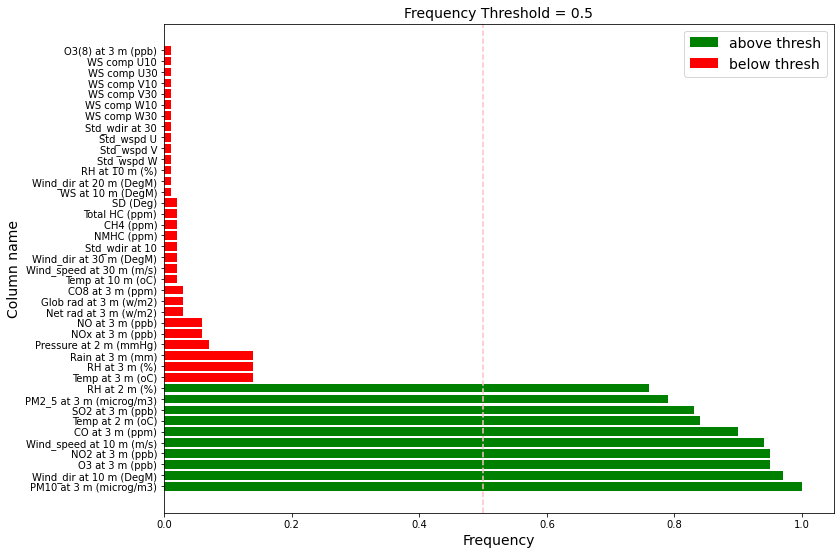

In [14]:
thresh = 0.5

COLUMNS_FREQ_COUNT_SORTED = sorted(COLUMNS_FREQ_COUNT.items(), key = lambda x: x[1])[::-1]

col_names_b_thresh = []
freq_b_thresh = []

col_names_a_thresh = []
freq_a_thresh = []

for (col_name, freq) in COLUMNS_FREQ_COUNT_SORTED:
    if col_name in ["date_time", "stationID"]:
        continue
    if freq < thresh:
        col_names_b_thresh.append(col_name)
        freq_b_thresh.append(freq)
    else:
        col_names_a_thresh.append(col_name)
        freq_a_thresh.append(freq)

plt.figure(figsize = (12, 9))
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Column name', fontsize = 14)
plt.barh(col_names_a_thresh, freq_a_thresh, color = 'green', label = 'above thresh')
plt.barh(col_names_b_thresh, freq_b_thresh, color = 'red', label = 'below thresh')
plt.axvline(thresh, linestyle = '--', color = 'pink')
plt.title(f"Frequency Threshold = {thresh}", fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [15]:
def adjust_column(df, removed_col, correct_col_ordered):
    col_delete = []
    #1) delete extra columns
    for c in df.schema.names:
        if c in removed_col:
            col_delete.append(c)
    df = df.drop(*col_delete)

    #2) add column
    for c in correct_col_ordered:
        if c not in df.schema.names:
            df = df.withColumn(c, F.lit(None))
    
    #3) rearrange order of the columns
    df = df.select(*correct_col_ordered)

    return df

In [16]:
correct_col_ordered = ['stationID', 'date_time'] + sorted(col_names_a_thresh)
removed_col = col_names_b_thresh

dfs_formatted = {}

for idx in range (df_stations.shape[0]):
    stationID = df_stations.iloc[idx]['stationID']

    if (idx+1)%10 == 0:
        print(f"[{get_current_dt()}] --> [{idx+1}/{df_stations.shape[0]}] Processing stationID: {stationID}")

    # adjust column 
    df_temp = adjust_column(dfs[stationID], removed_col, correct_col_ordered)

    # drop row with all null
    df_temp = df_temp.na.drop(how = "all", subset = sorted(col_names_a_thresh))

    # sort by 'date_time'
    dfs_formatted[stationID] = df_temp.sort('date_time')

print(f"[{get_current_dt()}] --> Finish Processing")

[2022-05-20 10:27:07] --> [10/86] Processing stationID: 12t
[2022-05-20 10:27:07] --> [20/86] Processing stationID: 22t
[2022-05-20 10:27:08] --> [30/86] Processing stationID: 30t
[2022-05-20 10:27:09] --> [40/86] Processing stationID: 36t
[2022-05-20 10:27:10] --> [50/86] Processing stationID: 43t
[2022-05-20 10:27:10] --> [60/86] Processing stationID: 58t
[2022-05-20 10:27:11] --> [70/86] Processing stationID: 69t
[2022-05-20 10:27:11] --> [80/86] Processing stationID: 78t
[2022-05-20 10:27:11] --> Finish Processing


## Check DataFrame

In [17]:
stationID = '35t'
row = 20
dfs[stationID].show(row)

+----------------+---------+---------------+---------------+---------------+----------------+----------------+----------------+-----------------------+--------------+---------+----------------------+----------+---------------------+----------------------+----------------+-------------+----------------+-----------------------+-----------------------+-----------+-----------+-----------+-----------+-----------+-----------+----------------+--------------+--------------+----------+----------+----------+------------------------+------------------------+------------------------+
|       date_time|stationID|CO at 3 m (ppm)|NO at 3 m (ppb)|O3 at 3 m (ppb)|NO2 at 3 m (ppb)|SO2 at 3 m (ppb)|NOx at 3 m (ppb)|PM10 at 3 m (microg/m3)|Total HC (ppm)|CH4 (ppm)|Glob rad at 3 m (w/m2)|NMHC (ppm)|Net rad at 3 m (w/m2)|Pressure at 2 m (mmHg)|Rain at 3 m (mm)|RH at 2 m (%)|Temp at 2 m (oC)|Wind_dir at 10 m (DegM)|Wind_dir at 30 m (DegM)|WS comp U10|WS comp U30|WS comp V10|WS comp V30|WS comp W10|WS comp W3

In [18]:
dfs_formatted[stationID].show(row)

+---------+----------------+---------------+----------------+---------------+-----------------------+------------------------+-------------+----------------+----------------+-----------------------+------------------------+
|stationID|       date_time|CO at 3 m (ppm)|NO2 at 3 m (ppb)|O3 at 3 m (ppb)|PM10 at 3 m (microg/m3)|PM2_5 at 3 m (microg/m3)|RH at 2 m (%)|SO2 at 3 m (ppb)|Temp at 2 m (oC)|Wind_dir at 10 m (DegM)|Wind_speed at 10 m (m/s)|
+---------+----------------+---------------+----------------+---------------+-----------------------+------------------------+-------------+----------------+----------------+-----------------------+------------------------+
|      35t|1995-06-04 00:00|           null|            null|           null|                   null|                    null|         86.0|            null|            27.4|                  249.0|                    null|
|      35t|1995-06-04 21:00|           null|            null|           null|                   null|   

In [ ]:
# dfs_imputed[stationID].show(row)

## Concatenate all stations

In [ ]:
def union_all(dfs):
    if len(dfs) > 1:
        return dfs[0].unionAll(union_all(dfs[1:]))
    else:
        return dfs[0]

In [ ]:
df_concated = union_all(list(dfs_formatted.values())).sort('date_time')
print(f'This DataFrame has {df_concated.count()} rows.')
print(f'This DataFrame has {len(df_concated.columns)} columns.')
df_concated.printSchema()
df_concated.show(30)

This DataFrame has 5603467 rows.
This DataFrame has 12 columns.
root
 |-- stationID: string (nullable = false)
 |-- date_time: string (nullable = true)
 |-- CO at 3 m (ppm): float (nullable = true)
 |-- NO2 at 3 m (ppb): float (nullable = true)
 |-- O3 at 3 m (ppb): float (nullable = true)
 |-- PM10 at 3 m (microg/m3): float (nullable = true)
 |-- PM2_5 at 3 m (microg/m3): float (nullable = true)
 |-- RH at 2 m (%): float (nullable = true)
 |-- SO2 at 3 m (ppb): float (nullable = true)
 |-- Temp at 2 m (oC): float (nullable = true)
 |-- Wind_dir at 10 m (DegM): float (nullable = true)
 |-- Wind_speed at 10 m (m/s): float (nullable = true)

+---------+----------------+---------------+----------------+---------------+-----------------------+------------------------+-------------+----------------+----------------+-----------------------+------------------------+
|stationID|       date_time|CO at 3 m (ppm)|NO2 at 3 m (ppb)|O3 at 3 m (ppb)|PM10 at 3 m (microg/m3)|PM2_5 at 3 m (microg/m3)|RH

# Save concatenated Dataframe into csv File

In [ ]:
BASE_PATH = './cleaned_data'
folder_name = 'cleaned_pcd_data_before'

BASE_SAVE_PATH = f'{BASE_PATH}/{folder_name}'

print(f'[{get_current_dt()}] --> Saving csv files to {BASE_SAVE_PATH}')

# saving csv file =============================================================================
df_concated.write.format('csv').option('header',True).mode('overwrite').option('sep',',').save(BASE_SAVE_PATH)
# ==============================================================================================

#renaming csv file and remove other files =====================================================
CSV_FILE_PATHS = []

for filename in os.listdir(BASE_SAVE_PATH):
    if filename.endswith('.csv'):
        part = int(filename.split('-')[1])
        new_filename = f'cleaned_pcd_data_before_part_{part}.csv'
        os.rename(f'{BASE_SAVE_PATH}/{filename}', f'{BASE_SAVE_PATH}/{new_filename}')
        CSV_FILE_PATHS.append(f'{BASE_SAVE_PATH}/{new_filename}')
    else:
        #remove other files
        os.remove(f'{BASE_SAVE_PATH}/{filename}')
#=============================================================================================

print(f"[{get_current_dt()}] --> Successfully save csv files!, There are total of {len(CSV_FILE_PATHS)} parts.")
for p in CSV_FILE_PATHS:
    print(p)

[2022-05-17 09:44:53] --> Saving csv files to ./cleaned_data/cleaned_pcd_data_before
[2022-05-17 09:51:19] --> Successfully save csv files!, There are total of 3 parts.
./cleaned_data/cleaned_pcd_data_before/cleaned_pcd_data_before_part_0.csv
./cleaned_data/cleaned_pcd_data_before/cleaned_pcd_data_before_part_1.csv
./cleaned_data/cleaned_pcd_data_before/cleaned_pcd_data_before_part_2.csv


# Load all saved csv files using Pandas, and combined it into single csv file

In [ ]:
dfs_2 = []
for fp in CSV_FILE_PATHS:
    dfs_2.append(pd.read_csv(fp))
df = pd.concat(dfs_2, axis = 0)
df['date_time'] = pd.to_datetime(df['date_time'], format  = '%Y-%m-%d %H:%M')
df.sort_values(by = 'date_time', inplace = True)
df.reset_index(drop = True, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5603467 entries, 0 to 5603466
Data columns (total 12 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   stationID                 object        
 1   date_time                 datetime64[ns]
 2   CO at 3 m (ppm)           float64       
 3   NO2 at 3 m (ppb)          float64       
 4   O3 at 3 m (ppb)           float64       
 5   PM10 at 3 m (microg/m3)   float64       
 6   PM2_5 at 3 m (microg/m3)  float64       
 7   RH at 2 m (%)             float64       
 8   SO2 at 3 m (ppb)          float64       
 9   Temp at 2 m (oC)          float64       
 10  Wind_dir at 10 m (DegM)   float64       
 11  Wind_speed at 10 m (m/s)  float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 513.0+ MB


In [ ]:
print(f"There are total {df.shape[0]} rows.")
df.head(10)

There are total 5603467 rows.


,stationID,date_time,CO at 3 m (ppm),NO2 at 3 m (ppb),O3 at 3 m (ppb),PM10 at 3 m (microg/m3),PM2_5 at 3 m (microg/m3),RH at 2 m (%),SO2 at 3 m (ppb),Temp at 2 m (oC),Wind_dir at 10 m (DegM),Wind_speed at 10 m (m/s)
0,35t,1995-06-04 00:00:00,NaN,NaN,NaN,NaN,NaN,86.0,NaN,27.4,249.0,NaN
1,35t,1995-06-04 21:00:00,NaN,NaN,NaN,NaN,NaN,75.0,NaN,29.1,166.0,NaN
2,35t,1995-06-04 22:00:00,NaN,NaN,NaN,NaN,NaN,80.0,NaN,28.4,208.0,NaN
3,35t,1995-06-04 23:00:00,NaN,NaN,NaN,NaN,NaN,84.0,NaN,28.0,194.0,NaN
4,35t,1995-06-05 00:00:00,NaN,NaN,NaN,NaN,NaN,87.0,NaN,27.6,168.0,NaN
5,35t,1995-06-05 01:00:00,NaN,NaN,NaN,NaN,NaN,89.0,NaN,26.8,119.0,NaN
6,35t,1995-06-05 02:00:00,NaN,NaN,NaN,NaN,NaN,90.0,NaN,26.6,264.0,NaN
7,35t,1995-06-05 03:00:00,NaN,NaN,NaN,NaN,NaN,95.0,NaN,25.9,150.0,NaN
8,35t,1995-06-05 04:00:00,NaN,NaN,NaN,NaN,NaN,98.0,NaN,25.5,262.0,NaN
9,35t,1995-06-05 05:00:00,NaN,NaN,NaN,NaN,NaN,98.0,NaN,25.2,220.0,NaN


In [ ]:
#Save Large csv File
df.to_csv(f'{BASE_PATH}/cleaned_pcd_data_before_all_parts.csv', index = False)

# Check and Observe final csv file

In [ ]:
df_final = pd.read_csv(f'{BASE_PATH}/cleaned_pcd_data_before_all_parts.csv')
df_final['date_time'] = pd.to_datetime(df_final['date_time'], format  = '%Y-%m-%d %H:%M')
df_final['stationID'] = df_final['stationID'].astype('string')
df_final

,stationID,date_time,CO at 3 m (ppm),NO2 at 3 m (ppb),O3 at 3 m (ppb),PM10 at 3 m (microg/m3),PM2_5 at 3 m (microg/m3),RH at 2 m (%),SO2 at 3 m (ppb),Temp at 2 m (oC),Wind_dir at 10 m (DegM),Wind_speed at 10 m (m/s)
0,35t,1995-06-04 00:00:00,NaN,NaN,NaN,NaN,NaN,86.0,NaN,27.4,249.0,NaN
1,35t,1995-06-04 21:00:00,NaN,NaN,NaN,NaN,NaN,75.0,NaN,29.1,166.0,NaN
2,35t,1995-06-04 22:00:00,NaN,NaN,NaN,NaN,NaN,80.0,NaN,28.4,208.0,NaN
3,35t,1995-06-04 23:00:00,NaN,NaN,NaN,NaN,NaN,84.0,NaN,28.0,194.0,NaN
4,35t,1995-06-05 00:00:00,NaN,NaN,NaN,NaN,NaN,87.0,NaN,27.6,168.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5603462,27t,2020-09-30 23:00:00,NaN,19.0,6.0,39.0,24.0,NaN,7.0,27.9,317.0,1.1
5603463,26t_1,2020-09-30 23:00:00,0.42,6.0,NaN,22.0,9.0,NaN,NaN,26.3,281.0,0.6
5603464,25t,2020-09-30 23:00:00,NaN,NaN,4.0,53.0,19.0,NaN,NaN,27.7,192.0,0.6
5603465,31t,2020-09-30 23:00:00,0.48,12.0,5.0,36.0,9.0,94.0,2.0,28.3,301.0,1.0


There are total of 86 stations.


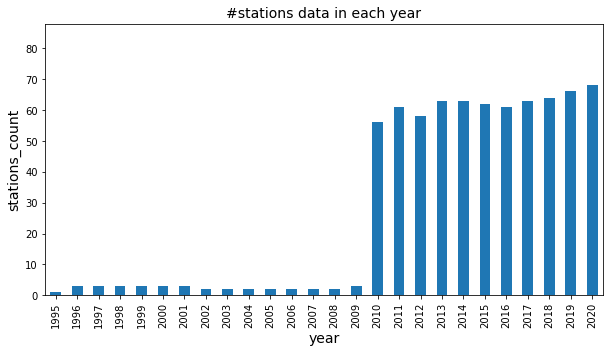

In [ ]:
df_final['year'] = df_final['date_time'].dt.year

total_stations = df_final['stationID'].nunique()
print(f"There are total of {total_stations} stations.")

plt.figure(figsize = (10, 5))
df_final.groupby('year')['stationID'].nunique().plot(kind = 'bar')
plt.xlabel('year', fontsize = 14)
plt.ylabel('stations_count', fontsize = 14)
plt.title('#stations data in each year', fontsize = 14)
plt.ylim([0, total_stations+2])
plt.show()

### Consider non-null values only year after 2010

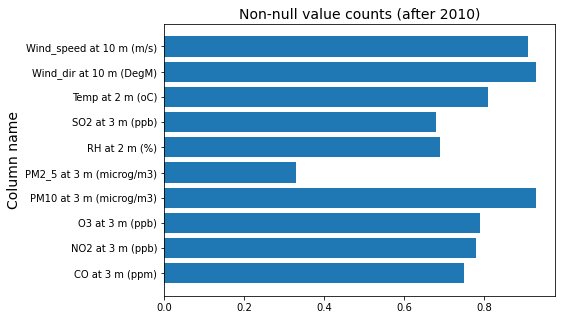

In [ ]:
df_final_tmp = df_final[df_final['year'] >= 2010]
non_null_count = list(map(lambda c: round(df_final_tmp[c].notna().sum()/df_final_tmp.shape[0], 2), list(df_final_tmp.columns)[2:12]))

plt.figure(figsize = (7, 5))
plt.ylabel('Column name', fontsize = 14)
plt.barh(list(df_final_tmp.columns)[2:12], non_null_count)
plt.title(f"Non-null value counts (after 2010)", fontsize = 14)
plt.show()

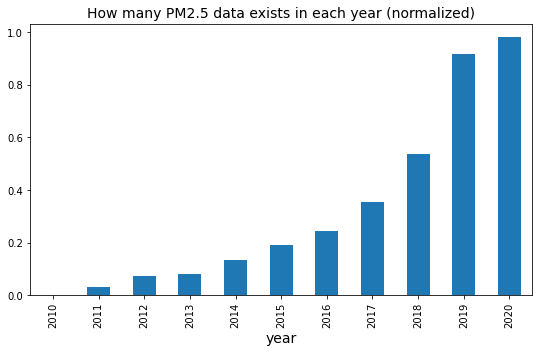

In [ ]:
pm25_exist_ratio = df_final_tmp.groupby('year')['PM2_5 at 3 m (microg/m3)'].count() / df_final_tmp.groupby('year')['date_time'].count()
plt.figure(figsize = (9, 5))
plt.xlabel('year', fontsize = 14)
plt.title('How many PM2.5 data exists in each year (normalized)', fontsize = 14)
pm25_exist_ratio.plot(kind = 'bar')
plt.show()